# BioMed: Information Retrieval - BioMedical Information Retrieval System

---

**Group:**
- Reyes Castro, Didier Yamil (didier.reyes.castro@alumnos.upm.es)
- Rodriguez Fernández, Cristina (cristina.rodriguezfernandez@alumnos.upm.es)

**Course:** BioMedical Informatics - 2025/26

**Institution:** Polytechnic University of Madrid (UPM)

**Date:** November 2026

---

## Goal

To develop an Information Retrieval system — specifically, a **binary text classifier** — to identify scientific articles in the PubMed database that are related to a given set of abstracts within a defined research topic. In this case, the focus is on a collection of 1,308 manuscripts containing information on the polyphenol composition of various foods.

## Setup and Installation

To run the code in this assignment, ensure you have the following libraries installed in your Python environment:

- requests
- pandas
- numpy
- scikit-learn
- transformers
- datasets
- pytorch

In [ ]:
# Uncomment the following line to install required packages
# !pip install scikit-learn pandas requests transformers pytorch datasets numpy

Loading the necessary libraries and defining constants.

In [1]:
import requests
import time, os
import torch
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, EarlyStoppingCallback
from datasets import Dataset
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report, roc_auc_score

In [2]:
BASE_URL = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/"
ESEARCH_URL = BASE_URL + "esearch.fcgi"
FETCH_URL = BASE_URL + "efetch.fcgi"

ELSEVIER_SEARCH_URL = "https://api.elsevier.com/content/search/scopus"
ELSEVIER_API_KEY = "<CHANGE_ME>"  # Replace with your Elsevier API key

DS_WITH_PMID = 'publications_pmid.csv'
PMID_ABSTRACTS = 'publications_pmid_abstract.csv'
ELSEVIER_ABSTRACTS = 'publications_abstract_pubmed_elsevier.csv'
NO_ABSTRACTS_OUTPUT_FILE = 'publications_no_abstract.csv'
IRRELEVANT_PUBLICATIONS = 'irrelevant_publications.csv'
COMBINED_PUBLICATIONS = 'combined_publications.csv'

## **Task 1:**

Retrieve from PubMed the abstracts associated with each publication in publications.csv

In [ ]:
dataset = pd.read_csv('publications.csv')
dataset

,id,authors,year_of_publication,title,abbreviation,journal_name,journal_volume,journal_issue,pages,created_at,updated_at
0,1216,"Aaby K., Wrolstad R.E., Ekeberg D., Skrede G.",2007,Polyphenol composition and antioxidant activit...,AABY 2007,Journal of Agricultural and Food Chemistry,55,13,5156-5166,2012-12-01 22:21:08 UTC,2015-04-14 04:25:30 UTC
1,1052,"Abd El Mohsen M.M., Kuhnle G., Rechner A.R., S...",2002,Uptake and metabolism of epicatechin and its a...,ABD EL MOHSEN 2002,Free Radic Biol Med,33,12,1693-702,2015-04-13 21:45:29 UTC,2015-04-14 04:25:30 UTC
2,356,"Abdel-Aal E.-S.M., Hucl P.",2003,Composition and stability of anthocyanins in b...,ABDEL-AAL 2003,Journal of Agricultural and Food Chemistry,51,NaN,2174-2180,2015-04-13 21:45:25 UTC,2015-04-14 04:25:30 UTC
3,458,"Abdel-Aal E.-S. M., Young C., Rabalski I.",2006,"Anthocyanin composition in black, blue, pink, ...",ABDEL-AAL 2006,Journal of Agricultural and Food Chemistry,54,NaN,4696-4704,2006-04-09 12:07:36 UTC,2015-04-14 04:25:31 UTC
4,332,"Abril M., Negueruela A.I., Perez C., Juan T., ...",2005,Preliminary study of resveratrol content in Ar...,Apr-05,Food Chemistry,92,4,729-736,2015-04-13 21:45:25 UTC,2015-04-13 21:45:25 UTC
...,...,...,...,...,...,...,...,...,...,...,...
1303,816,"Zielinski H., Kozlowska H., Lewczuk B.",2001,Bioactive compounds in the cereal grains befor...,ZIELINSKI 2001,Innovative Food Science and Emerging Technologies,2,NaN,159-169,2015-04-13 21:45:28 UTC,2015-04-13 21:45:28 UTC
1304,497,"Zielinski H., Michalska A., Piskula M.K., Kozl...",2006,Antioxidants in thermally treated buckwheat gr...,ZIELINSKI 2006,Molecular Nutrition and Food Research,50,NaN,824-832,2015-04-13 21:45:26 UTC,2015-04-14 13:51:47 UTC
1305,743,"Zimmermann R., Bauermann U., Morales F.",2006,Effects of growing site and nitrogen fertiliza...,ZIMMERMANN 2006,Journal of the Science of Food and Agriculture,86,NaN,415-419,2015-04-13 21:45:27 UTC,2015-04-13 21:45:27 UTC
1306,203,"Zuo Y., Wang C., Zhan J.",2002,"Separation, characterization and quantitation ...",ZUO 2002,Journal of Agricultural and Food Chemistry,50,13,3789-3794,2015-04-13 21:45:24 UTC,2015-04-14 13:51:48 UTC


Defining the functions that searches the PMID of the articles and retrieves the abstracts from PubMed.

In [ ]:
def search_pmid(article):

    title = article['title']
    params = {
        "db": "pubmed",
        "term": f"{title}",
        "retmode": "json",
        "field": "title"
    }

    try:

        # Trying to find the PMID
        response = requests.get(ESEARCH_URL, params=params)
        response.raise_for_status()
        data = response.json()

        if len(data["esearchresult"]["idlist"]) >= 1:
            pmid = data['esearchresult']['idlist'][0]
            print(f"> Found PMID for article: {pmid}")
            return pmid

        print(f"> No PMID found for article.")
        return None

    except requests.exceptions.RequestException as e:
        print(f"> ERROR during request for article: {e}")
        return None

def fetch_abstract_by_pmid(pmid):
    params = {
        "db": "pubmed",
        "id": f"{pmid}",
        "retmode": "text",
        "rettype": "abstract",
    }

    try:
        response = requests.get(FETCH_URL, params=params)
        response.raise_for_status()
        print(f"> Fetched abstract!!")
        return response.text
    except requests.exceptions.RequestException as e:
        print(f"> ERROR fetching abstract for PMID '{pmid}': {e}")
        return None

Running the code to get the abstracts from PubMed.

In [ ]:
# Step 1: Search for the PMID of the articles by title
ds_pmid = dataset.copy()
for idx, article in ds_pmid.iterrows():
    print(f"[{idx + 1}/{len(ds_pmid)}] Searching PMID for: {article['title']}")
    pmid = search_pmid(article)
    ds_pmid.at[idx, 'pmid'] = pmid

In [ ]:
ds_pmid.to_csv(DS_WITH_PMID, index=False)
print("Number of articles with PMID found:", ds_pmid['pmid'].notnull().sum())

In [ ]:
# Step 2: Fetch article abstract by PMID
ds_pmid_abstract = ds_pmid.copy()
for idx, article in ds_pmid_abstract.iterrows():
    pmid = article['pmid']
    if pd.notnull(pmid):
        print(f"[{idx + 1}/{len(ds_pmid_abstract)}] Fetching abstract for PMID: {pmid}")
        abstract = fetch_abstract_by_pmid(pmid)
        ds_pmid_abstract.at[idx, 'abstract'] = abstract
    else:
        print(f"[{idx + 1}/{len(ds_pmid_abstract)}] No PMID available, skipping abstract fetch.")
        ds_pmid_abstract.at[idx, 'abstract'] = None

In [ ]:
ds_pmid_abstract.to_csv(PMID_ABSTRACTS, index=False)
print("Number of articles with abstract fetched:", ds_pmid_abstract['abstract'].notnull().sum())
print("Number of articles without abstract fetched:", ds_pmid_abstract['abstract'].isnull().sum())

Now, searching abstracts through the Elsevier API.

**You must have an API key from Elsevier to run this code. Also, be inside UPM network!!**

In [ ]:
def search_scopus(article_row, api_key):

    try:

        title = article_row.get('title', '').replace('"', '') # Remove quotes for query
        headers = {"Accept": "application/json"}
        params = {
            "query": f"TITLE-ABS-KEY(\"{title}\")",
            "apiKey": api_key
        }

        response = requests.get(ELSEVIER_SEARCH_URL,
                                headers=headers, params=params, timeout=10)
        response.raise_for_status()
        data = response.json()

        if 'search-results' in data and data['search-results']['entry']:
            try:
                return data['search-results']['entry'][0]['prism:url']
            except KeyError:
                return None
        return None

    except requests.exceptions.RequestException as e:
        print(f"> Scopus ERROR: {e}")

In [ ]:
ds_elsevier = pd.read_csv(PMID_ABSTRACTS)

counters = {
    'total_missing': ds_elsevier['abstract'].isnull().sum(),
    'elsevier_found': 0,
    'failed': 0
}

for i, row in ds_elsevier.iterrows():

    if not pd.isnull(row['abstract']):
        continue

    print(f"[{i + 1}/{len(ds_elsevier)}] Searching ELSEVIER for abstract of article: {row['title']}")
    abstract_url = search_scopus(row, ELSEVIER_API_KEY)

    if abstract_url:
        response = requests.get(abstract_url,
                                headers={"Accept": "application/json",
                                         "X-ELS-APIKey": ELSEVIER_API_KEY})
        if response.status_code == 200:
            data = response.json()
            try:
                abstract_text = data['abstracts-retrieval-response']['coredata']['dc:description']
                ds_elsevier.at[i, 'abstract'] = abstract_text
                print("> Found abstract via ELSEVIER!")
                counters['elsevier_found'] += 1
            except KeyError:
                print("> Abstract not found in ELSEVIER response.")
                counters['failed'] += 1
    else:
        print("> Nope :(")
        counters['failed'] += 1

    time.sleep(1) # Polite 1-second delay

ds_elsevier.to_csv(ELSEVIER_ABSTRACTS, index=False)
print("Summary of ELSEVIER abstract search:")
print(f"Total missing abstracts at start: {counters['total_missing']}")
print(f"Abstracts found via ELSEVIER: {counters['elsevier_found']}")
print(f"Failed attempts: {counters['failed']}")

Saving the publications with no abstract (after EUtilities and Elsevier search) in a csv file.

In [ ]:
if os.path.exists(ELSEVIER_ABSTRACTS):
    try:
        # Load the dataset
        final_df = pd.read_csv(ELSEVIER_ABSTRACTS)

        print(f"Total number of publications: {len(final_df)}")
        missing_abstracts_df = final_df[final_df['abstract'].isnull()]

        num_missing = len(missing_abstracts_df)

        if num_missing > 0:
            print(f"Found {num_missing} publications without abstract")
            missing_abstracts_df.to_csv(NO_ABSTRACTS_OUTPUT_FILE, index=False, encoding='utf-8')

            print(f"{num_missing} publications loaded in: {NO_ABSTRACTS_OUTPUT_FILE}")

        else:
            print("No publications without abstract!")

    except Exception as e:
        print(f"An error ocurred processing: {e}")

else:
    print(f"Error: file not found: '{ELSEVIER_ABSTRACTS}'.")

## **Task 2:**

Use the EUtilities tool to search for articles whose content is not relevant to this task. Size of the dataset should be the same of relevant documents. In our case, the main topic is **"cancer"**.

In [ ]:
def get_articles_pmids_for_title(title, count):

    params = {
        "db": "pubmed",
        "term": f"{title}[tiab]",
        "retmode": "json",
        "retmax": count
    }

    try:
        response = requests.get(ESEARCH_URL, params=params)
        response.raise_for_status()
        data = response.json()

        if 'esearchresult' in data and data['esearchresult']['count'] != '0':
            print(f"Found {data['esearchresult']['count']} articles.")
            return data['esearchresult']['idlist']
        else:
            print(f"Found {data['esearchresult']['count']} irrelevant articles.")
            return []

    except requests.exceptions.RequestException as e:
        print(f"Error during request for irrelevant articles: {e}")
        return []


In [ ]:
final_df = pd.read_csv(ELSEVIER_ABSTRACTS)
num_with_abstracts = final_df['abstract'].notnull().sum()

irrelevant_pmids_list = get_articles_pmids_for_title("cancer", int(num_with_abstracts))
irrelevant_abstracts = []
for i, pmid in enumerate(irrelevant_pmids_list):

    article_info = {
        'pmid': pmid,
        'abstract': None
    }

    print(f"[{i + 1}/{len(irrelevant_pmids_list)}] Fetching abstract for PMID: {pmid}")
    article_info['abstract'] = fetch_abstract_by_pmid(pmid)
    irrelevant_abstracts.append(article_info)

# Save irrelevant abstracts to a new dataset
irrelevant_df = pd.DataFrame(irrelevant_abstracts)
irrelevant_df.to_csv(IRRELEVANT_PUBLICATIONS, index=False)

Found 2529778 articles.
[1/1203] Fetching abstract for PMID: 41204822
> Fetched abstract!!
[2/1203] Fetching abstract for PMID: 41204804
> Fetched abstract!!
[3/1203] Fetching abstract for PMID: 41204791
> Fetched abstract!!
[4/1203] Fetching abstract for PMID: 41204774
> Fetched abstract!!
[5/1203] Fetching abstract for PMID: 41204772
> Fetched abstract!!
[6/1203] Fetching abstract for PMID: 41204766
> Fetched abstract!!
[7/1203] Fetching abstract for PMID: 41204749
> Fetched abstract!!
[8/1203] Fetching abstract for PMID: 41204725
> Fetched abstract!!
[9/1203] Fetching abstract for PMID: 41204722
> Fetched abstract!!
[10/1203] Fetching abstract for PMID: 41204717
> Fetched abstract!!
[11/1203] Fetching abstract for PMID: 41204712
> Fetched abstract!!
[12/1203] Fetching abstract for PMID: 41204710
> Fetched abstract!!
[13/1203] Fetching abstract for PMID: 41204697
> Fetched abstract!!
[14/1203] Fetching abstract for PMID: 41204684
> Fetched abstract!!
[15/1203] Fetching abstract for P

## **Task 4:**

Implement the chosen retrieval system using the programming language of their choice. If the information retrieval system is based on machine learning techniques, the student must split the existing datasets (relevant and non-relevant documents) into three distinct groups (training, validation, and testing) to carry out the model training.

**CHOSEN RETRIEVAL SYSTEM:** BioBERT-based Binary Text Classifier

In [3]:
# Loading datasets
relevant_df = pd.read_csv(ELSEVIER_ABSTRACTS)
relevant_df = relevant_df[relevant_df['abstract'].notnull()] # Keep only relevant articles with abstracts
irrelevant_df = pd.read_csv(IRRELEVANT_PUBLICATIONS)

print("Relevant articles shape:", relevant_df.shape)
print("Irrelevant articles shape:", irrelevant_df.shape)

Relevant articles shape: (1203, 13)
Irrelevant articles shape: (1203, 2)


In [4]:
# Adding target variable 'relevance'
relevant_df['relevance'] = 1
irrelevant_df['relevance'] = 0

# Combining relevant and irrelevant datasets and maintaining only abstract and relevance columns
features = ['abstract', 'relevance']
combined_df = pd.concat([relevant_df[features], irrelevant_df[features]], ignore_index=True)

# Remove any rows where the abstract is missing (e.g., API fetch failed)
combined_df.dropna(subset=['abstract'], inplace=True)
combined_df.reset_index(drop=True, inplace=True)

# Saving
combined_df.to_csv(COMBINED_PUBLICATIONS, index=False)

print("Class distribution:")
print(combined_df['relevance'].value_counts())

combined_df

Class distribution:
relevance
1    1203
0    1202
Name: count, dtype: int64


,abstract,relevance
0,1. J Agric Food Chem. 2007 Jun 27;55(13):5156-...,1
1,1. Free Radic Biol Med. 2002 Dec 15;33(12):169...,1
2,1. J Agric Food Chem. 2003 Apr 9;51(8):2174-80...,1
3,1. J Agric Food Chem. 2006 Jun 28;54(13):4696-...,1
4,A survey of resveratrol content in wines of th...,1
...,...,...
2400,1. J Am Coll Radiol. 2025 Nov;22(11S):S492-S50...,0
2401,1. Am J Clin Nutr. 2025 Nov;122(5):1195-1203. ...,0
2402,1. West J Emerg Med. 2025 Sep 25;26(5):1211-12...,0
2403,1. J Gene Med. 2025 Nov;27(11):e70047. doi: 10...,0


Following Fine-tuning of BERT for text classification tasks: https://huggingface.co/docs/transformers/en/tasks/sequence_classification

- Train-Test-Validation Split: 80%-10%-10%

In [27]:
RANDOM_STATE = 42

train_df, test_df = train_test_split(combined_df,
                                     test_size=0.2,
                                     stratify=combined_df["relevance"],
                                     random_state=RANDOM_STATE)

val_df, test_df = train_test_split(test_df,
                                   test_size=0.5,
                                   stratify=test_df["relevance"],
                                   random_state=RANDOM_STATE)

print(f"Training size: {len(train_df)}")
print(f"Validation size: {len(val_df)}")
print(f"Test size: {len(test_df)}")

Training size: 1924
Validation size: 240
Test size: 241


- Convert Pandas DataFrame to HuggingFace Dataset

In [28]:
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

- Tokenization of abstracts using BioBERT tokenizer

In [29]:
BERT_MODEL_NAME = "dmis-lab/biobert-v1.1"
tokenizer = AutoTokenizer.from_pretrained(BERT_MODEL_NAME)

def tokenize(examples):
    return tokenizer(examples["abstract"],
                     padding="max_length",
                     truncation=True,
                     max_length=512 # Maximum length for BERT models
                    )

train_dataset = train_dataset.map(tokenize, batched=True)
val_dataset = val_dataset.map(tokenize, batched=True)
test_dataset = test_dataset.map(tokenize, batched=True)

# Renaming the target column to 'labels' as expected by HuggingFace Trainer
train_dataset = train_dataset.rename_column("relevance", "labels")
val_dataset = val_dataset.rename_column("relevance", "labels")
test_dataset = test_dataset.rename_column("relevance", "labels")

Map:   0%|          | 0/1924 [00:00<?, ? examples/s]

Map:   0%|          | 0/240 [00:00<?, ? examples/s]

Map:   0%|          | 0/241 [00:00<?, ? examples/s]

- Loading BioBERT model for binary text classification (relevant vs irrelevant)

In [30]:
id2label = {0: "irrelevant", 1: "relevant"}
label2id = {"irrelevant": 0, "relevant": 1}

model = AutoModelForSequenceClassification.from_pretrained(BERT_MODEL_NAME,
                                                           num_labels=2,
                                                           id2label=id2label,
                                                           label2id=label2id)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


- Defining evaluation metrics

In [31]:
def precision_at_k(y_true, y_score, k):
    order = np.argsort(y_score)[::-1]
    y_true_sorted = np.array(y_true)[order]
    top_k = y_true_sorted[:k]
    return np.mean(top_k)

def r_precision(y_true, y_score):
    R = int(np.sum(y_true))
    return precision_at_k(y_true, y_score, R) if R > 0 else 0

def average_precision(y_true, y_score):
    order = np.argsort(y_score)[::-1]
    y_true_sorted = np.array(y_true)[order]
    precisions = []
    relevant = 0
    for i, val in enumerate(y_true_sorted, start=1):
        if val == 1:
            relevant += 1
            precisions.append(relevant / i)
    return np.mean(precisions) if precisions else 0

def reciprocal_rank(y_true, y_score):
    order = np.argsort(y_score)[::-1]
    y_true_sorted = np.array(y_true)[order]
    for i, val in enumerate(y_true_sorted, start=1):
        if val == 1:
            return 1 / i
    return 0

def f_measure(precision, recall, beta=1.0):
    return (1 + beta**2) * (precision * recall) / (beta**2 * precision + recall) if (precision + recall) else 0



def compute_metrics(eval_pred):
    logits, labels = eval_pred
    probs = logits[:, 1]  # probabilities of being relevant
    predictions = np.argmax(logits, axis=-1)

    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average="binary", zero_division=0)

    # IR Metrics
    p_at_5 = precision_at_k(labels, probs, 5)
    p_at_10 = precision_at_k(labels, probs, 10)
    r_prec = r_precision(labels, probs)
    avg_prec = average_precision(labels, probs)
    rr = reciprocal_rank(labels, probs)
    auroc = roc_auc_score(labels, probs)
    f_beta_2 = f_measure(precision, recall, beta=2.0)  # Ejemplo con β=2

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "F2": f_beta_2,
        "AUROC": auroc,
        "P@5": p_at_5,
        "P@10": p_at_10,
        "R-Precision": r_prec,
        "AvgPrecision": avg_prec,
        "ReciprocalRank": rr
    }


- Putting the training arguments

In [32]:
training_args = TrainingArguments(
    output_dir="./biobert_pubmed_classifier",

    # Training hyperparameters
    num_train_epochs=3,
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,

    # Optimiser settings
    weight_decay=0.01,

    # Evaluation settings
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_steps=100,

    # Model selection
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,

    # Performance
    fp16=torch.cuda.is_available(),
    dataloader_num_workers=4,

    seed=RANDOM_STATE,
    push_to_hub=False,
    report_to="none"
)

- Actual training using Trainer API

In [33]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

trainer.train()

/tmp/ipython-input-3549236244.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,F2,Auroc,P@5,P@10,R-precision,Avgprecision,Reciprocalrank
1,0.112100,0.005272,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2,0.015200,0.000816,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
3,0.005400,0.001483,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


TrainOutput(global_step=363, training_loss=0.038147815823883394, metrics={'train_runtime': 172.9822, 'train_samples_per_second': 33.368, 'train_steps_per_second': 2.098, 'total_flos': 1518677011537920.0, 'train_loss': 0.038147815823883394, 'epoch': 3.0})

- Evaluating on the test set

In [34]:
predictions_output = trainer.predict(test_dataset)
predictions = np.argmax(predictions_output.predictions, axis=-1)
true_labels = predictions_output.label_ids

# Calculate all metrics
test_metrics = compute_metrics((predictions_output.predictions, true_labels))

print("\nTest Set Results:")
print(f"Accuracy:  {test_metrics['accuracy']:.4f}")
print(f"Precision: {test_metrics['precision']:.4f}")
print(f"Recall:    {test_metrics['recall']:.4f}")
print(f"F1-Score:  {test_metrics['f1']:.4f}")

print("\nRanked Results:")
print(f"AUROC:          {test_metrics['AUROC']:.4f}")
print(f"P@5:            {test_metrics['P@5']:.4f}")
print(f"P@10:           {test_metrics['P@10']:.4f}")
print(f"R-Precision:    {test_metrics['R-Precision']:.4f}")
print(f"Avg Precision:  {test_metrics['AvgPrecision']:.4f}")
print(f"ReciprocalRank: {test_metrics['ReciprocalRank']:.4f}")

# Detailed classification report
print("\nClassification Report:")
print(classification_report(
    true_labels,
    predictions,
    target_names=['Irrelevant', 'Relevant'],
    digits=4
))

# Confusion matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(true_labels, predictions)
print(cm)
print(f"\nTrue Negatives:  {cm[0][0]} (correctly identified irrelevant)")
print(f"False Positives: {cm[0][1]} (incorrectly marked relevant)")
print(f"False Negatives: {cm[1][0]} (missed relevant papers)")
print(f"True Positives:  {cm[1][1]} (correctly identified relevant)")

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



Test Set Results:
Accuracy:  0.9917
Precision: 0.9917
Recall:    0.9917
F1-Score:  0.9917

Ranked Results:
AUROC:          0.9999
P@5:            1.0000
P@10:           1.0000
R-Precision:    0.9917
Avg Precision:  0.9999
ReciprocalRank: 1.0000

Classification Report:
              precision    recall  f1-score   support

  Irrelevant     0.9917    0.9917    0.9917       120
    Relevant     0.9917    0.9917    0.9917       121

    accuracy                         0.9917       241
   macro avg     0.9917    0.9917    0.9917       241
weighted avg     0.9917    0.9917    0.9917       241


Confusion Matrix:
[[119   1]
 [  1 120]]

True Negatives:  119 (correctly identified irrelevant)
False Positives: 1 (incorrectly marked relevant)
False Negatives: 1 (missed relevant papers)
True Positives:  120 (correctly identified relevant)


- saving the trained model

In [35]:
model_save_path = './final_biobert_classifier'
trainer.save_model(model_save_path)
tokenizer.save_pretrained(model_save_path)

('./final_biobert_classifier/tokenizer_config.json',
 './final_biobert_classifier/special_tokens_map.json',
 './final_biobert_classifier/vocab.txt',
 './final_biobert_classifier/added_tokens.json',
 './final_biobert_classifier/tokenizer.json')

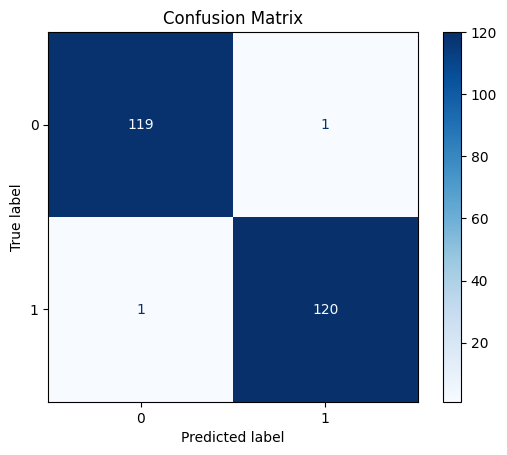

In [36]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(true_labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

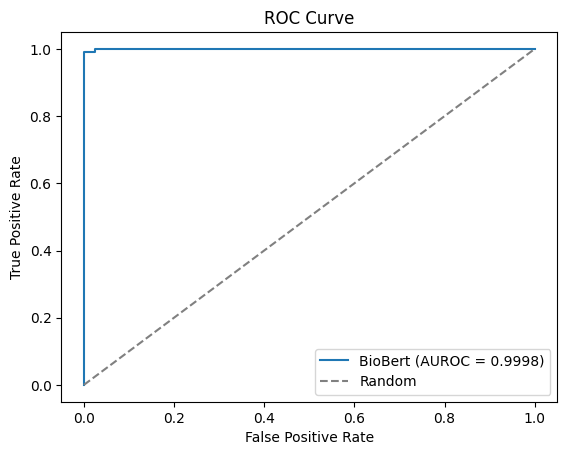

In [37]:
# AUROC Curve
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

logits = predictions_output.predictions
labels = predictions_output.label_ids

# 1. Calculamos las probabilidades (scores) a partir de los logits
y_prob = F.softmax(torch.tensor(logits), dim=-1)[:, 1].numpy()

# 2. Calculamos FPR, TPR y el score AUROC usando las variables correctas
fpr, tpr, thresholds = roc_curve(labels, y_prob)
auc_score = roc_auc_score(labels, y_prob)

# 3. Graficamos la curva ROC
plt.figure()
plt.plot(fpr, tpr, label=f'BioBert (AUROC = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()
